## Load libraries

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re
import os
import gensim
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pd.options.mode.chained_assignment = None  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhaolongjiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load/Clean data

In [3]:
uk = pd.read_excel('UK_tweet_data.xlsx')
uk.head()

FileNotFoundError: [Errno 2] No such file or directory: 'UK_tweet_data.xlsx'

In [3]:
uk_cleaned = uk.drop_duplicates(subset = ['Tweets', 'Account', 'Likes'], keep = 'last')
uk_cleaned.shape

(10754, 5)

In [4]:
uk_cleaned.loc[:,'Region'] = uk_cleaned['Hashtag'].apply(lambda x: x.upper()[:2])
uk_cleaned.head()

,Tweets,Time,Account,Likes,Hashtag,Region
1829,The “vote no” crowd left leaflets in my letter...,Feb 28,@mneylon,"1 reply, 293 views",uk since:2024-02-01 until:2024-02-29 immigration,UK
1830,I for one am fed up of the outrage mob using f...,Feb 28,@Brenbyrn2,"1 reply, 7 likes, 169 views",uk since:2024-02-01 until:2024-02-29 immigration,UK
1831,"But Starmer, Khan and his cronies want more im...",Feb 28,@smupp1,5 views,uk since:2024-02-01 until:2024-02-29 immigration,UK
1832,"""Tired of garlic struggles? Say goodbye to the...",Feb 28,@Splazzastore,"11 replies, 13 reposts, 85 likes, 36 bookmarks...",uk since:2024-02-01 until:2024-02-29 immigration,UK
1833,"Biden’s approval rate on immigration is 35%, b...",Feb 28,@DavidDeeble,"5 likes, 108 views",uk since:2024-02-01 until:2024-02-29 immigration,UK


In [5]:
uk_cleaned.loc[:,'Month'] = uk_cleaned['Hashtag'].apply(lambda x: x[9:16])
uk_cleaned = uk_cleaned.drop(columns = 'Hashtag')
uk_cleaned['Likes'] = uk_cleaned['Likes'].fillna('none')
uk_cleaned.head()

,Tweets,Time,Account,Likes,Region,Month
1829,The “vote no” crowd left leaflets in my letter...,Feb 28,@mneylon,"1 reply, 293 views",UK,2024-02
1830,I for one am fed up of the outrage mob using f...,Feb 28,@Brenbyrn2,"1 reply, 7 likes, 169 views",UK,2024-02
1831,"But Starmer, Khan and his cronies want more im...",Feb 28,@smupp1,5 views,UK,2024-02
1832,"""Tired of garlic struggles? Say goodbye to the...",Feb 28,@Splazzastore,"11 replies, 13 reposts, 85 likes, 36 bookmarks...",UK,2024-02
1833,"Biden’s approval rate on immigration is 35%, b...",Feb 28,@DavidDeeble,"5 likes, 108 views",UK,2024-02


In [6]:
uk_cleaned.to_csv('UK_tweet_data.csv', index = False)

## Analysis

### Influence

In [7]:
repost_filter = uk_cleaned['Likes'].str.contains('repost')
uk_cleaned.loc[repost_filter, 'Reposts'] = uk_cleaned.loc[repost_filter, 'Likes'].apply(lambda x: re.findall('(\d+[.,]?\d*)(?:[\s\d\-\+\/]*)(?:repost)', x)[0]).astype('int')   
uk_cleaned.loc[~repost_filter, 'Reposts'] = 0
uk_cleaned[['Likes', 'Reposts']].head(10)

<>:2: DeprecationWarning: invalid escape sequence '\d'
<>:2: DeprecationWarning: invalid escape sequence '\d'
C:\Users\PC\AppData\Local\Temp\ipykernel_21920\2265528259.py:2: DeprecationWarning: invalid escape sequence '\d'
  uk_cleaned.loc[repost_filter, 'Reposts'] = uk_cleaned.loc[repost_filter, 'Likes'].apply(lambda x: re.findall('(\d+[.,]?\d*)(?:[\s\d\-\+\/]*)(?:repost)', x)[0]).astype('int')


,Likes,Reposts
1829,"1 reply, 293 views",0.0
1830,"1 reply, 7 likes, 169 views",0.0
1831,5 views,0.0
1832,"11 replies, 13 reposts, 85 likes, 36 bookmarks...",13.0
1833,"5 likes, 108 views",0.0
1834,"1 reply, 1 repost, 1 like, 654 views",1.0
1835,34 views,0.0
1836,27 views,0.0
1837,"1 reply, 3 likes, 61 views",0.0
1838,"1 reply, 2 likes, 46 views",0.0


In [8]:
print(len(uk_cleaned[uk_cleaned.Reposts >= 10]))
uk_cleaned['Influential'] = np.where(uk_cleaned.Reposts >= 10, 'yes', 'no')
uk_cleaned.head()

1224


,Tweets,Time,Account,Likes,Region,Month,Reposts,Influential
1829,The “vote no” crowd left leaflets in my letter...,Feb 28,@mneylon,"1 reply, 293 views",UK,2024-02,0.0,no
1830,I for one am fed up of the outrage mob using f...,Feb 28,@Brenbyrn2,"1 reply, 7 likes, 169 views",UK,2024-02,0.0,no
1831,"But Starmer, Khan and his cronies want more im...",Feb 28,@smupp1,5 views,UK,2024-02,0.0,no
1832,"""Tired of garlic struggles? Say goodbye to the...",Feb 28,@Splazzastore,"11 replies, 13 reposts, 85 likes, 36 bookmarks...",UK,2024-02,13.0,yes
1833,"Biden’s approval rate on immigration is 35%, b...",Feb 28,@DavidDeeble,"5 likes, 108 views",UK,2024-02,0.0,no


### Sentiment and topic, Overall

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    res = [[word for word in simple_preprocess(str(doc)) 
             if (word not in stop_words) & (word not in ['https', 'com'])] for doc in texts]
    return res

data = uk_cleaned.Tweets.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['vote', 'crowd', 'left', 'leaflets', 'letterbox', 'today', 'apparently', 'mass', 'immigration']


In [10]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [11]:
from pprint import pprint
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       alpha = 'symmetric',
                                       eta = 'auto',
                                       random_state = 9)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.050*"immigration" + 0.008*"people" + 0.005*"get" + 0.004*"one" + '
  '0.004*"country" + 0.004*"uk" + 0.004*"illegal" + 0.004*"labour" + '
  '0.004*"stop" + 0.004*"like"'),
 (1,
  '0.043*"immigration" + 0.007*"uk" + 0.006*"people" + 0.006*"brexit" + '
  '0.005*"illegal" + 0.004*"eu" + 0.004*"mass" + 0.003*"right" + 0.003*"get" + '
  '0.003*"us"'),
 (2,
  '0.055*"immigration" + 0.007*"uk" + 0.007*"people" + 0.006*"would" + '
  '0.006*"illegal" + 0.005*"country" + 0.004*"right" + 0.004*"us" + '
  '0.004*"labour" + 0.004*"need"')]


topic 1 (0): illegal, labour

topic 2 (2): government, tories

topic 3 (1): eu, visa, brexit

In [1]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

NameError: name 'pyLDAvis' is not defined

#### Sentiment analysis

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def tweet_sentiment(tweet):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(tweet)
    return ss['compound']

uk_cleaned['Sentiment'] = uk_cleaned['Tweets'].apply(tweet_sentiment)
uk_cleaned.head()

,Tweets,Time,Account,Likes,Region,Month,Reposts,Influential,Sentiment
1829,The “vote no” crowd left leaflets in my letter...,Feb 28,@mneylon,"1 reply, 293 views",UK,2024-02,0.0,no,0.0000
1830,I for one am fed up of the outrage mob using f...,Feb 28,@Brenbyrn2,"1 reply, 7 likes, 169 views",UK,2024-02,0.0,no,-0.5106
1831,"But Starmer, Khan and his cronies want more im...",Feb 28,@smupp1,5 views,UK,2024-02,0.0,no,0.7351
1832,"""Tired of garlic struggles? Say goodbye to the...",Feb 28,@Splazzastore,"11 replies, 13 reposts, 85 likes, 36 bookmarks...",UK,2024-02,13.0,yes,-0.8202
1833,"Biden’s approval rate on immigration is 35%, b...",Feb 28,@DavidDeeble,"5 likes, 108 views",UK,2024-02,0.0,no,0.2617


<AxesSubplot: >

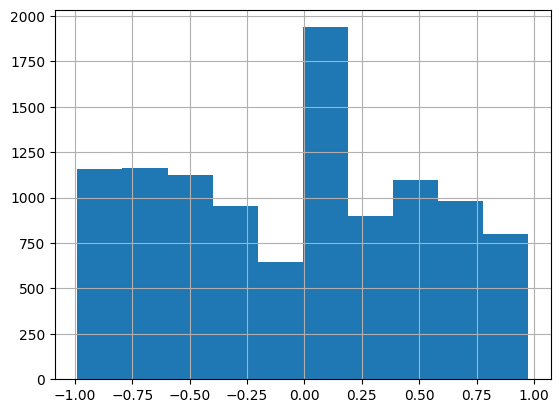

In [14]:
uk_cleaned['Sentiment'].hist()

Topical sentiment

In [64]:
def topic_classify(text, lda_model):
    #clean_text = remove_stopwords(sent_to_words(text))
    clean_text = text.split()
    new_text_corpus =  id2word.doc2bow(clean_text)
    lda_res = lda_model[new_text_corpus]
    res = max(lda_res, key=lambda item: item[1])[0]
    return 'topic ' + str(res)

In [65]:
uk_cleaned['topic_class'] = uk_cleaned['Tweets'].apply(lambda x: topic_classify(x, lda_model))
uk_cleaned['topic_class'].value_counts()

topic_class
topic 0    4177
topic 2    3859
topic 1    2718
Name: count, dtype: int64

In [66]:
topic_pct = uk_cleaned.groupby('topic_class')['Sentiment'].apply(lambda x: [100*(x<0).sum()/len(x), 100*(x==0).sum()/len(x), 100*(x>0).sum()/len(x)])
topic_dict = topic_pct.to_dict()
topic_dict

{'topic 0': [44.45774479291357, 13.861623174527173, 41.68063203255925],
 'topic 1': [49.96320824135394, 10.89036055923473, 39.14643119941133],
 'topic 2': [47.473438714692925, 12.619849701995335, 39.90671158331174]}

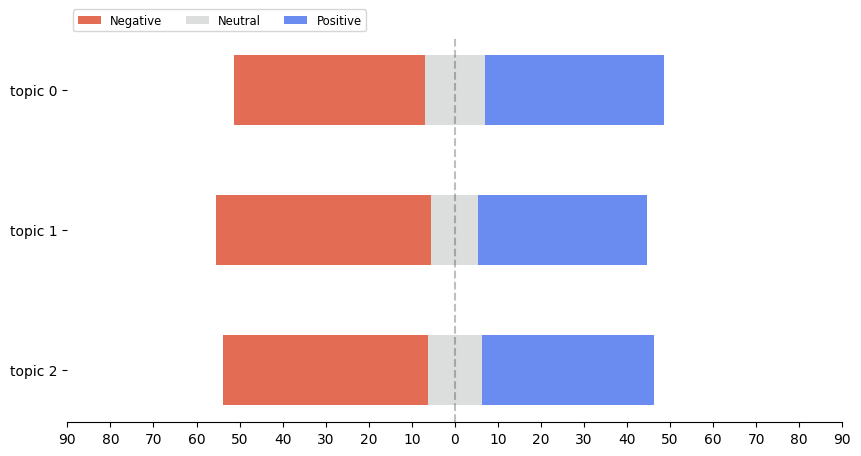

In [67]:
import matplotlib.pyplot as plt

category_names = ['Negative', 'Neutral', 'Positive']
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1]//2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    ax.set_xlim(-90, 90)
    ax.set_xticks(np.arange(-90, 91, 10))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Ledgend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')

    return fig, ax


fig, ax = survey(topic_pct.to_dict(), category_names)
plt.show()

### Sentiment and topic, influence

In [69]:
inf_data = uk_cleaned[uk_cleaned.Influential == 'yes'].Tweets.values.tolist()
inf_words = list(sent_to_words(data))
# remove stop words
inf_words = remove_stopwords(inf_words)
print(inf_words[:1][0][:30])

['vote', 'crowd', 'left', 'leaflets', 'letterbox', 'today', 'apparently', 'mass', 'immigration']


In [70]:
import gensim.corpora as corpora
# Create Dictionary
inf_id2word = corpora.Dictionary(inf_words)
# Create Corpus
inf_texts = inf_words
# Term Document Frequency
inf_corpus = [id2word.doc2bow(text) for text in inf_texts]
# View
print(inf_corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [71]:
from pprint import pprint
# number of topics
inf_num_topics = 3
# Build LDA model
inf_lda_model = gensim.models.LdaMulticore(corpus=inf_corpus,
                                       id2word=inf_id2word,
                                       num_topics=inf_num_topics,
                                       alpha = 'symmetric',
                                       eta = 'auto',
                                       random_state = 9)
# Print the Keyword in the 10 topics
pprint(inf_lda_model.print_topics())
inf_doc_lda = inf_lda_model[inf_corpus]

[(0,
  '0.050*"immigration" + 0.008*"people" + 0.005*"get" + 0.004*"one" + '
  '0.004*"country" + 0.004*"uk" + 0.004*"illegal" + 0.004*"labour" + '
  '0.004*"stop" + 0.004*"like"'),
 (1,
  '0.043*"immigration" + 0.007*"uk" + 0.006*"people" + 0.006*"brexit" + '
  '0.005*"illegal" + 0.004*"eu" + 0.004*"mass" + 0.003*"right" + 0.003*"get" + '
  '0.003*"us"'),
 (2,
  '0.055*"immigration" + 0.007*"uk" + 0.007*"people" + 0.006*"would" + '
  '0.006*"illegal" + 0.005*"country" + 0.004*"right" + 0.004*"us" + '
  '0.004*"labour" + 0.004*"need"')]


topic 1 (0): EU asylum

topic 2 (2):  uk, brexit, britain

topic 3 (1): labour, work

In [62]:
# Visualize the topics
pyLDAvis.enable_notebook()
inf_LDAvis_data_filepath = os.path.join('inf_ldavis_prepared_'+str(inf_num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    inf_LDAvis_prepared = pyLDAvis.gensim.prepare(inf_lda_model, inf_corpus, inf_id2word)
    with open(inf_LDAvis_data_filepath, 'wb') as f:
        pickle.dump(inf_LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(inf_LDAvis_data_filepath, 'rb') as f:
    inf_LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(inf_LDAvis_prepared, 'inf_ldavis_prepared_'+ str(inf_num_topics) +'.html')
inf_LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.018395  0.022755       1        1  35.967842
0     -0.032085  0.002339       2        1  34.845809
1      0.013690 -0.025094       3        1  29.186348, topic_info=         Term        Freq       Total Category  logprob  loglift
910    brexit  627.000000  627.000000  Default  30.0000  30.0000
555     would  601.000000  601.000000  Default  29.0000  29.0000
1414     free  320.000000  320.000000  Default  28.0000  28.0000
1165  seconds   66.000000   66.000000  Default  27.0000  27.0000
1167   upload   61.000000   61.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
345      like  161.724479  615.619177   Topic3  -5.8413  -0.1053
530     legal  115.350123  370.234460   Topic3  -6.1792   0.0653
503   country  133.510503  721.130638   Topic3  -6.0330  -0.4552
313    policy  123.747836  542.897677   Topic3  -6.1090  -0.2472
103    labour  114.061049  632.421323   Topic3  -6.1905  -0.4814

[287 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1155       1  0.096572         ai
1155       2  0.730322         ai
1155       3  0.175036         ai
788        1  0.607034    allowed
788        2  0.237123    allowed
...      ...       ...        ...
445        1  0.068130     画像タッフて
445        2  0.885686     画像タッフて
11141      3  0.906567    耐久性もアッフ
446        1  0.136241  選手かいち早く体感
446        2  0.885567  選手かいち早く体感

[507 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [72]:
inf_sent = uk_cleaned.loc[uk_cleaned.Influential == 'yes', 'Tweets'].apply(tweet_sentiment)

<AxesSubplot: >

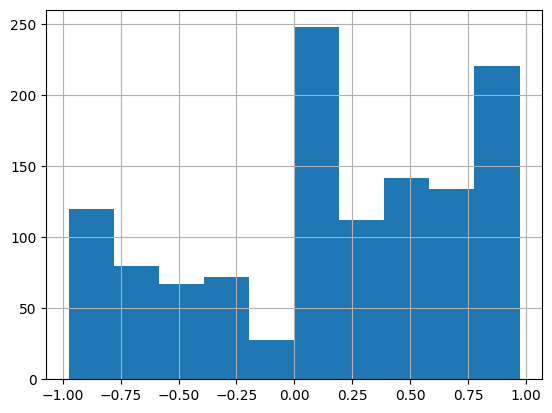

In [73]:
inf_sent.hist()

In [75]:
uk_inf = uk_cleaned[uk_cleaned.Influential == 'yes']
uk_inf['inf_topic_class'] = uk_inf['Tweets'].apply(lambda x: topic_classify(x, inf_lda_model))
uk_inf['inf_topic_class'].value_counts()

inf_topic_class
topic 0    578
topic 2    362
topic 1    284
Name: count, dtype: int64

In [77]:
inf_topic_pct = uk_inf.groupby('topic_class')['Sentiment'].apply(lambda x: [100*(x<0).sum()/len(x), 100*(x==0).sum()/len(x), 100*(x>0).sum()/len(x)])
inf_topic_dict = inf_topic_pct.to_dict()
inf_topic_dict

{'topic 0': [23.883161512027492, 20.790378006872853, 55.32646048109966],
 'topic 1': [34.73684210526316, 15.43859649122807, 49.824561403508774],
 'topic 2': [36.134453781512605, 12.605042016806722, 51.260504201680675]}

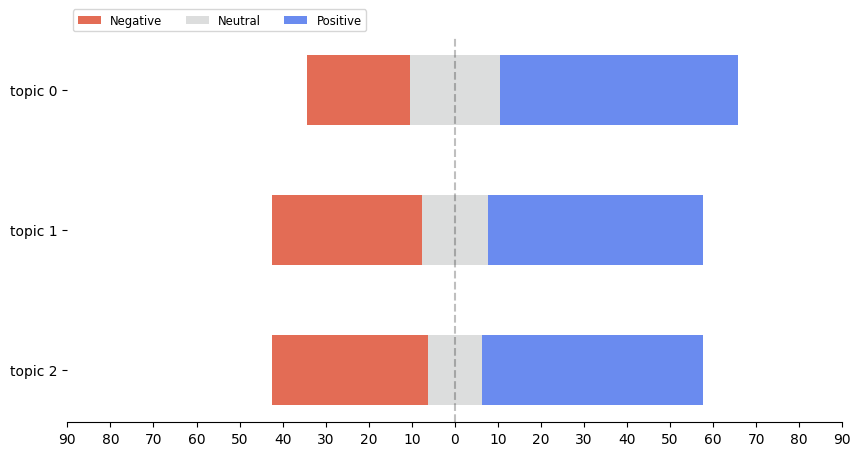

In [78]:
fig, ax = survey(inf_topic_dict, category_names)
plt.show()